# 第6回講義 演習

## 課題1. Denoising Autoencoderの実装. また, MNISTを用いて次のことを確認
- reconstruction errorが小さくなっている（学習が進んでいる）
- 重みの可視化（特徴の可視化）

In [85]:
%matplotlib inline

from __future__ import division
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
from theano.tensor.shared_randomstreams import RandomStreams
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T

rng = np.random.RandomState(1234)
theano_rng = RandomStreams(rng.randint(1234))

### 1. MNISTデータセットの読み込み

In [86]:
mnist = fetch_mldata('MNIST original')
mnist_X, mnist_y = shuffle(mnist.data.astype('float32'), mnist.target.astype('int32'))

mnist_X = mnist_X / 255

train_X, test_X, train_y, test_y = train_test_split(mnist_X, mnist_y, test_size=0.2)

In [87]:
train_y = np.eye(10)[train_y].astype('int32')
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

### 2. Autoencoderをクラスとして定義

In [88]:
class Autoencoder:
    #- Constructor
    def __init__(self, visible_dim, hidden_dim, function):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.function = function
        self.W = theano.shared(rng.uniform(low=-0.08, high=0.08, size=(visible_dim, hidden_dim)).astype('float32'), name='W')
        self.a = theano.shared(np.zeros(visible_dim).astype('float32'), name='a')
        self.b = theano.shared(np.zeros(hidden_dim).astype('float32'), name='b')
        self.params = [self.W, self.a, self.b]
    
    #- Encoder
    def encode(self, x):
        u = T.dot(x, self.W) + self.b
        y = self.function(u)
        return y
    
    #- Decoder (Tied Weight)
    def decode(self, x):
        u = T.dot(x, self.W.T) + self.a
        y = self.function(u)
        return y
    
    #- Forward Propagation
    def f_prop(self, x):
        y = self.encode(x)
        reconst_x = self.decode(y)
        return reconst_x
    
    #- Reconstruction Error
    def reconst_error(self, x, noise):
        tilde_x = x * noise
        reconst_x = self.f_prop(tilde_x)
        error = T.mean(T.sum(T.nnet.binary_crossentropy(reconst_x, x), axis=1))
        return error, reconst_x

### 3. 確率的勾配法 (Stochastic Gradient Descent)

In [115]:
def sgd(params, g_params, eps=np.float32(0.01)):
    updates = OrderedDict()
    for param, g_param in zip(params, g_params):
        updates[param] = param - eps*g_param
    return updates

### 4. モデルの構築および学習

#### 4.1 Corruption level=0の場合

In [90]:
model = Autoencoder(train_X.shape[1], 500, T.nnet.sigmoid)

x = T.fmatrix('x')
noise = T.fmatrix('noise')

cost, reconst_x = model.reconst_error(x, noise)
params = model.params
g_params = T.grad(cost=cost, wrt=params)
updates = sgd(params, g_params)

train = theano.function(inputs=[x, noise], outputs=[cost, reconst_x], updates=updates, allow_input_downcast=True, name='train')

corruption_level = np.float32(0.0)
batch_size = 100
n_batches = train_X.shape[0] // batch_size

#- Epoch
for epoch in xrange(10):
    train_X = shuffle(train_X)
    err_all = []
    for i in xrange(0, n_batches):
        start = i * batch_size
        end = start + batch_size
        
        noise = rng.binomial(size=train_X[start:end].shape, n=1, p=1-corruption_level)
        err, reconst_x = train(train_X[start:end], noise)
        err_all.append(err)
    print 'Epoch:%d, Error:%lf' % (epoch, np.mean(err))

weight_0 = model.W.get_value(borrow=True).T

Epoch:0, Error:70.205009
Epoch:1, Error:62.885014
Epoch:2, Error:61.628227
Epoch:3, Error:59.555840
Epoch:4, Error:58.225941
Epoch:5, Error:55.994297
Epoch:6, Error:55.326218
Epoch:7, Error:56.369774
Epoch:8, Error:55.090633
Epoch:9, Error:52.937988


#### 4.2 Corruption level=0.5の場合

In [91]:
model = Autoencoder(train_X.shape[1], 500, T.nnet.sigmoid)

x = T.fmatrix('x')
noise = T.fmatrix('noise')

cost, reconst_x = model.reconst_error(x, noise)
params = model.params
g_params = T.grad(cost=cost, wrt=params)
updates = sgd(params, g_params)

train = theano.function(inputs=[x, noise], outputs=[cost, reconst_x], updates=updates, allow_input_downcast=True, name='train')

corruption_level = np.float32(0.5)
batch_size = 100
n_batches = train_X.shape[0] // batch_size

#- Epoch
for epoch in xrange(10):
    train_X = shuffle(train_X)
    err_all = []
    for i in xrange(0, n_batches):
        start = i * batch_size
        end = start + batch_size
        
        noise = rng.binomial(size=train_X[start:end].shape, n=1, p=1-corruption_level)
        err, reconst_x = train(train_X[start:end], noise)
        err_all.append(err)
    print 'Epoch:%d, Error:%lf' % (epoch, np.mean(err))

weight_1 = model.W.get_value(borrow=True).T

Epoch:0, Error:102.560974
Epoch:1, Error:98.897087
Epoch:2, Error:92.373871
Epoch:3, Error:93.905518
Epoch:4, Error:87.134964
Epoch:5, Error:87.071754
Epoch:6, Error:84.798973
Epoch:7, Error:83.190941
Epoch:8, Error:83.768463
Epoch:9, Error:82.992050


### 5. 重みの可視化
- corruption_levelの違いによる重みの違いを観測

#### 5.1 Corruption level=0の場合

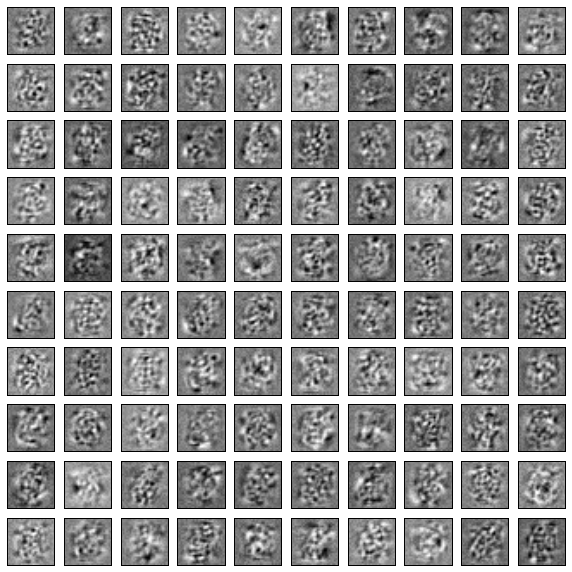

In [92]:
fig = plt.figure(figsize=(10, 10))
for i in xrange(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight_0[i].reshape((28, 28)), cmap='gray')

#### 5.2 Corruption level=0.5の場合

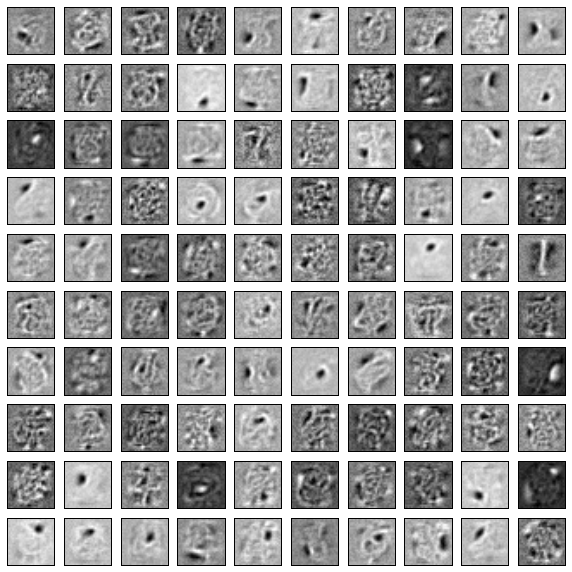

In [93]:
fig = plt.figure(figsize=(10, 10))
for i in xrange(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight_1[i].reshape((28, 28)), cmap='gray')

## 課題2. Stacked Denoising Autoencoder (SdA) の実装

### 1. SdA用のAutoencoderクラス

In [98]:
class Autoencoder:
    #- Constructor
    def __init__(self, visible_dim, hidden_dim, W, function):
        self.visible_dim = visible_dim
        self.hidden_dim  = hidden_dim
        self.function    = function
        self.W           = W
        self.a = theano.shared(np.zeros(visible_dim).astype('float32'), name='a')
        self.b = theano.shared(np.zeros(hidden_dim).astype('float32'), name='b')
        self.params = [self.W, self.a, self.b]

    #- Encoder
    def encode(self, x):
        u = T.dot(x, self.W) + self.b
        y = self.function(u)
        return y

    #- Decoder
    def decode(self, x):
        u = T.dot(x, self.W.T) + self.a
        y = self.function(u)
        return y

    #- Forward Propagation
    def f_prop(self, x):
        y = self.encode(x)
        reconst_x = self.decode(y)
        return reconst_x

    #- Reconstruction Error
    def reconst_error(self, x, noise):
        tilde_x = x * noise
        reconst_x = self.f_prop(tilde_x)
        error = T.mean(T.sum(T.nnet.binary_crossentropy(reconst_x, x), axis=1))
        return error, reconst_x

### 2. SdA用のLayerクラス

In [117]:
class Layer:
    #- Constructor
    def __init__(self, in_dim, out_dim, function):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.function = function
        self.W = theano.shared(rng.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype('float32'), name='W')
        self.b = theano.shared(np.zeros(out_dim).astype('float32'), name='b')
        self.params = [self.W, self.b]

        self.set_pretraining()

    #- Forward Propagation
    def f_prop(self, x):
        self.u = T.dot(x, self.W) + self.b
        self.z = self.function(self.u)
        return self.z

    #- Set Pretraining
    def set_pretraining(self):
        ae = Autoencoder(self.in_dim, self.out_dim, self.W, self.function)

        x = T.fmatrix(name='x')
        noise = T.fmatrix(name='noise')

        cost, reconst_x = ae.reconst_error(x, noise)
        params = ae.params
        g_params = T.grad(cost=cost, wrt=params)
        updates = sgd(params, g_params)

        self.pretraining = theano.function(inputs=[x, noise], outputs=[cost, reconst_x], updates=updates, allow_input_downcast=True, name='pretraining')

        hidden = ae.encode(x)
        self.encode_function = theano.function(inputs=[x], outputs=hidden, allow_input_downcast=True, name='encode_function')

### 3. ネットワークの定義

In [118]:
layers = [
    Layer(784, 200, T.nnet.sigmoid),
    Layer(200, 10, T.nnet.softmax),
]

### 4. 事前学習 (Pre-training)

In [119]:
X = train_X
for l, layer in enumerate(layers[:-1]):
    corruption_level = np.float32(0.3)
    batch_size = 100
    n_batches = X.shape[0] // batch_size

    for epoch in xrange(10):
        X = shuffle(X)
        err_all = []
        for i in xrange(0, n_batches):
            start = i*batch_size
            end = start + batch_size

            noise = rng.binomial(size=X[start:end].shape, n=1, p=1-corruption_level)
            err, reconst_x = layer.pretraining(X[start:end], noise)
            err_all.append(err)
        print 'Pretraining:: layer:%d, Epoch:%d, Error:%lf' % (l, epoch, np.mean(err))
    X = layer.encode_function(X)

Pretraining:: layer:0, Epoch:0, Error:149.322571
Pretraining:: layer:0, Epoch:1, Error:133.860123
Pretraining:: layer:0, Epoch:2, Error:117.702072
Pretraining:: layer:0, Epoch:3, Error:110.044060
Pretraining:: layer:0, Epoch:4, Error:104.966286
Pretraining:: layer:0, Epoch:5, Error:106.320480
Pretraining:: layer:0, Epoch:6, Error:103.691856
Pretraining:: layer:0, Epoch:7, Error:96.221504
Pretraining:: layer:0, Epoch:8, Error:95.928673
Pretraining:: layer:0, Epoch:9, Error:92.722794


### 5. train関数, valid関数, test関数

In [ ]:
x = T.fmatrix(name='x')
t = T.imatrix(name='t')

params = []
for i, layer in enumerate(layers):
    params += layer.params
    if i == 0:
        layer_out = layer.f_prop(x)
    else:
        layer_out = layer.f_prop(layer_out)

y = layers[-1].z
cost = T.mean(T.nnet.categorical_crossentropy(y, t))

g_params = T.grad(cost=cost, wrt=params)
updates = sgd(params, g_params)

train = theano.function(inputs=[x, t], outputs=cost, updates=updates, allow_input_downcast=True, name='train')
valid = theano.function(inputs=[x, t], outputs=[cost, T.argmax(y, axis=1)], allow_input_downcast=True, name='valid')
test  = theano.function([x], T.argmax(y, axis=1), name='test')

### 6. 学習 (Fine-tuning)

In [ ]:
batch_size = 100
n_batches = train_X.shape[0]//batch_size

for epoch in xrange(300):
    train_X, train_y = shuffle(train_X, train_y)
    for i in xrange(n_batches):
        start = i*batch_size
        end = start + batch_size
        train(train_X[start:end], train_y[start:end])
    if epoch % 10 == 0:
        valid_cost, pred_y = valid(valid_X, valid_y)
        print 'EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f' % (epoch + 1, valid_cost, f1_score(np.argmax(valid_y, axis=1).astype('int32'), pred_y, average='macro'))

EPOCH:: 1, Validation cost: 2.299, Validation F1: 0.104
EPOCH:: 11, Validation cost: 2.297, Validation F1: 0.089
EPOCH:: 21, Validation cost: 2.295, Validation F1: 0.069
EPOCH:: 31, Validation cost: 2.296, Validation F1: 0.116
EPOCH:: 41, Validation cost: 2.295, Validation F1: 0.105
EPOCH:: 51, Validation cost: 2.297, Validation F1: 0.091
EPOCH:: 61, Validation cost: 2.298, Validation F1: 0.106
EPOCH:: 71, Validation cost: 2.296, Validation F1: 0.106
EPOCH:: 81, Validation cost: 2.302, Validation F1: 0.097
EPOCH:: 91, Validation cost: 2.297, Validation F1: 0.086
EPOCH:: 101, Validation cost: 2.303, Validation F1: 0.105
EPOCH:: 111, Validation cost: 2.304, Validation F1: 0.109
EPOCH:: 121, Validation cost: 2.305, Validation F1: 0.101
EPOCH:: 131, Validation cost: 2.309, Validation F1: 0.104
EPOCH:: 141, Validation cost: 2.308, Validation F1: 0.103
EPOCH:: 151, Validation cost: 2.308, Validation F1: 0.108
